# Experiment

- run linear program with NEM trading price + NEM marginal carbon intensity
- optimize for prices and carbon + the space inbetween

Before running this notebook, need to run `$ make expt-space-between` in the `energy-py-linear` folder.

## Dataset Preparation

In [1]:
!pip install pandas -Uq
from pathlib import Path
import pandas as pd


def load_nem_data(table, region=None, region_col='REGIONID'):
    anchor = Path.home() / 'nem-data' / 'data' / table
    clean = anchor.glob('**/clean.parquet')
    fis = [pd.read_parquet(f) for f in clean]
    data = pd.concat(fis, axis=0)

    if region:
        mask = data[region_col] == region
        data = data.loc[mask, :]
    return data

You should consider upgrading via the '/Users/adam/.pyenv/versions/3.7.9/envs/epl/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
region = 'SA1'
prices = load_nem_data('TRADINGPRICE', region)
prices = prices.drop_duplicates().set_index('interval-start')
prices = prices.resample('5T').ffill()
prices.head(2)

,I,TRADING,PRICE,2,SETTLEMENTDATE,RUNNO,REGIONID,PERIODID,RRP,EEP,INVALIDFLAG,LASTCHANGED,ROP,RAISE6SECRRP,RAISE6SECROP,RAISE60SECRRP,RAISE60SECROP,RAISE5MINRRP,RAISE5MINROP,RAISEREGRRP,RAISEREGROP,LOWER6SECRRP,LOWER6SECROP,LOWER60SECRRP,LOWER60SECROP,LOWER5MINRRP,LOWER5MINROP,LOWERREGRRP,LOWERREGROP,PRICE_STATUS,interval-end,timestamp
interval-start,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,D,TRADING,PRICE,2.0,2014-01-01 00:30:00,1.0,SA1,1.0,44.56,0.0,0.0,2014/01/01 00:25:04,44.56,0.57,0.57,0.43,0.43,0.81,0.81,0.81,0.81,0.07,0.07,0.13,0.13,0.27,0.27,0.38,0.38,FIRM,2014-01-01 00:30:00,2014-01-01 00:30:00
2014-01-01 00:05:00,D,TRADING,PRICE,2.0,2014-01-01 00:30:00,1.0,SA1,1.0,44.56,0.0,0.0,2014/01/01 00:25:04,44.56,0.57,0.57,0.43,0.43,0.81,0.81,0.81,0.81,0.07,0.07,0.13,0.13,0.27,0.27,0.38,0.38,FIRM,2014-01-01 00:30:00,2014-01-01 00:30:00


In [3]:
sites = pd.read_csv("http://www.nemweb.com.au/Reports/CURRENT/CDEII/CO2EII_AVAILABLE_GENERATORS.CSV", skiprows=1).iloc[:-1, :]
sites.head(2)

,I,CO2EII,PUBLISHING,1,STATIONNAME,DUID,GENSETID,REGIONID,CO2E_EMISSIONS_FACTOR,CO2E_ENERGY_SOURCE,CO2E_DATA_SOURCE
0,D,CO2EII,PUBLISHING,1.0,West Nowra Landfill Gas Power Generation Facility,AGLNOW1,AGLNOW1,NSW1,0.083,Landfill biogas methane,NGA 2020
1,D,CO2EII,PUBLISHING,1.0,AGL KEMPS CREEK,AGLSITA1,AGLSITA1,NSW1,0.083,Landfill biogas methane,NGA 2020


## Carbon Data

Carbon data needs a bit of work - select only ENOF rows:

In [4]:
carbon = load_nem_data('nemde', region, 'RegionID')

In [5]:
carbon['PeriodID'] = pd.to_datetime(carbon['PeriodID'])
carbon['PeriodID'] = carbon['PeriodID'].dt.tz_localize(None)
carbon

,PeriodID,RegionID,Market,Price,Unit,DispatchedMarket,BandNo,Increase,RRNBandPrice,BandCost
26,2017-11-07 23:20:00,SA1,Energy,65.31349,TARONG#1,ENOF,4.0,0.33608,64.78,21.771162
27,2017-11-07 23:20:00,SA1,Energy,65.31349,TARONG#4,ENOF,4.0,0.33608,64.78,21.771162
28,2017-11-07 23:20:00,SA1,Energy,65.31349,TARONG#2,ENOF,4.0,0.33608,64.78,21.771162
29,2017-11-07 23:20:00,SA1,R6SE,15.00000,VP5,R6SE,5.0,-1.00000,15.00,-15.000000
30,2017-11-07 23:20:00,SA1,R60S,2.80000,ER03,R60S,2.0,-1.00000,2.80,-2.800000
...,...,...,...,...,...,...,...,...,...,...
40,2017-05-18 12:05:00,SA1,R5RE,19.87046,BW01,R6SE,1.0,0.60550,0.01,0.006055
41,2017-05-18 12:05:00,SA1,L6SE,0.02000,LOYYB2,L6SE,2.0,-1.00000,0.02,-0.020000
42,2017-05-18 12:05:00,SA1,L60S,0.02000,LOYYB1,L60S,2.0,-1.00000,0.02,-0.020000
43,2017-05-18 12:05:00,SA1,L5MI,0.19000,LOYYB1,L5MI,3.0,-1.00000,0.19,-0.190000


In [6]:
mask = carbon['Market'] == 'Energy'
carbon = carbon.loc[mask, :]

mask = carbon['DispatchedMarket'] == 'ENOF'
carbon = carbon.loc[mask, :]

carbon['PeriodID'] = pd.to_datetime(carbon['PeriodID'])

Want to join on NEM Sites

In [7]:
sites.head(2)

,I,CO2EII,PUBLISHING,1,STATIONNAME,DUID,GENSETID,REGIONID,CO2E_EMISSIONS_FACTOR,CO2E_ENERGY_SOURCE,CO2E_DATA_SOURCE
0,D,CO2EII,PUBLISHING,1.0,West Nowra Landfill Gas Power Generation Facility,AGLNOW1,AGLNOW1,NSW1,0.083,Landfill biogas methane,NGA 2020
1,D,CO2EII,PUBLISHING,1.0,AGL KEMPS CREEK,AGLSITA1,AGLSITA1,NSW1,0.083,Landfill biogas methane,NGA 2020


In [8]:
carbon.head(2)

,PeriodID,RegionID,Market,Price,Unit,DispatchedMarket,BandNo,Increase,RRNBandPrice,BandCost
26,2017-11-07 23:20:00,SA1,Energy,65.31349,TARONG#1,ENOF,4.0,0.33608,64.78,21.771162
27,2017-11-07 23:20:00,SA1,Energy,65.31349,TARONG#4,ENOF,4.0,0.33608,64.78,21.771162


In [9]:
carbon = carbon.merge(sites[['DUID', 'REGIONID', 'CO2E_EMISSIONS_FACTOR']], left_on='Unit', right_on='DUID', how='left')

In [10]:
mask = carbon['CO2E_EMISSIONS_FACTOR'].isnull()
carbon = carbon.loc[~mask, :]
assert carbon.isnull().sum().sum() == 0

In [11]:
carbon['carbon_generation_[tc/h]'] = carbon['CO2E_EMISSIONS_FACTOR'] * carbon['Increase']

carbon = carbon.set_index('PeriodID')

In [12]:
grp = carbon.groupby(carbon.index).agg({
    'carbon_generation_[tc/h]': 'sum',
    'Increase': 'sum',
})

In [13]:
grp.sort_values('Increase').head(4)

,carbon_generation_[tc/h],Increase
PeriodID,,
2015-02-21 15:50:00,9.742226,-30.68509
2019-10-20 17:35:00,-12.210256,-17.18396
2020-12-07 17:15:00,-11.489711,-16.84106
2018-05-09 04:25:00,-6.212068,-13.00724


In [14]:
carbon.head(2)

,RegionID,Market,Price,Unit,DispatchedMarket,BandNo,Increase,RRNBandPrice,BandCost,DUID,REGIONID,CO2E_EMISSIONS_FACTOR,carbon_generation_[tc/h]
PeriodID,,,,,,,,,,,,,
2017-11-07 23:20:00,SA1,Energy,65.31349,TARONG#1,ENOF,4.0,0.33608,64.78,21.771162,TARONG#1,QLD1,0.871459,0.29288
2017-11-07 23:20:00,SA1,Energy,65.31349,TARONG#4,ENOF,4.0,0.33608,64.78,21.771162,TARONG#4,QLD1,0.871459,0.29288


Drop wind for coal:

In [15]:
carbon.loc[
    '2014-01-01 12:00:00', :
]

,RegionID,Market,Price,Unit,DispatchedMarket,BandNo,Increase,RRNBandPrice,BandCost,DUID,REGIONID,CO2E_EMISSIONS_FACTOR,carbon_generation_[tc/h]
PeriodID,,,,,,,,,,,,,
2014-01-01 12:00:00,SA1,Energy,55.91283,POAT220,ENOF,6.0,-11.15101,36.34,-405.227679,POAT220,TAS1,0.000000,-0.000000
2014-01-01 12:00:00,SA1,Energy,55.91283,ER01,ENOF,3.0,2.34512,49.69,116.528973,ER01,NSW1,0.910143,2.134395
2014-01-01 12:00:00,SA1,Energy,55.91283,ER04,ENOF,3.0,2.34512,49.69,116.528973,ER04,NSW1,0.910143,2.134395
2014-01-01 12:00:00,SA1,Energy,55.91283,ER02,ENOF,3.0,2.34512,49.69,116.528973,ER02,NSW1,0.910143,2.134395
2014-01-01 12:00:00,SA1,Energy,55.91283,ER03,ENOF,3.0,2.34512,49.69,116.528973,ER03,NSW1,0.910143,2.134395


In [16]:
ds = prices.merge(carbon, how='left', left_index=True, right_index=True).sort_index()
print(ds.columns)

ds = ds.loc[:,[
    'RRP', 'Increase'
]]
ds.head(3)

Index(['I', 'TRADING', 'PRICE', '2', 'SETTLEMENTDATE', 'RUNNO', 'REGIONID_x', 'PERIODID', 'RRP', 'EEP', 'INVALIDFLAG', 'LASTCHANGED', 'ROP', 'RAISE6SECRRP', 'RAISE6SECROP', 'RAISE60SECRRP', 'RAISE60SECROP', 'RAISE5MINRRP', 'RAISE5MINROP', 'RAISEREGRRP', 'RAISEREGROP', 'LOWER6SECRRP', 'LOWER6SECROP', 'LOWER60SECRRP', 'LOWER60SECROP', 'LOWER5MINRRP', 'LOWER5MINROP', 'LOWERREGRRP', 'LOWERREGROP', 'PRICE_STATUS', 'interval-end', 'timestamp', 'RegionID', 'Market', 'Price', 'Unit', 'DispatchedMarket', 'BandNo', 'Increase', 'RRNBandPrice', 'BandCost', 'DUID', 'REGIONID_y', 'CO2E_EMISSIONS_FACTOR', 'carbon_generation_[tc/h]'], dtype='object')


,RRP,Increase
2014-01-01 00:00:00,44.56,NaN
2014-01-01 00:05:00,44.56,NaN
2014-01-01 00:10:00,44.56,NaN


In [17]:
ds = ds.dropna(axis=0)
assert ds.isnull().sum().sum() == 0
ds.to_parquet('./results/price-carbon-signals.parquet')

In [18]:
ds.shape

(1807795, 2)

## Battery Modelling

In [19]:
!pip install -q pandas==1.3.3 fastparquet
import energypylinear as epl

You should consider upgrading via the '/Users/adam/.pyenv/versions/3.7.9/envs/epl/bin/python3.7 -m pip install --upgrade pip' command.


In [20]:
mdl = epl.Battery(power=2, capacity=4)
mdl

Battery(power=2.0, capacity=4.0, eff=0.9)

Want to see profit versus carbon per year

Also look at correlation between price & average carbon

In [21]:
subset = ds.iloc[:1000, :]

opt_price = mdl.optimize(
    prices=subset['RRP'], carbon=subset['Increase'], objective='price'
)

 Battery(power=2.0, capacity=4.0, eff=0.9), Optimal


In [22]:
carbon_opt = mdl.optimize(
    prices=subset['RRP'], carbon=subset['Increase'], objective='carbon'
)

 Battery(power=2.0, capacity=4.0, eff=0.9), Optimal


In [23]:
opt_price = pd.DataFrame(opt_price)
cols = [c for c in opt_price.columns if 'Cost' in c]
opt_price.sum()[cols]

Actual Cost [$/5T]     -302.992833
Forecast Cost [$/5T]   -302.992833
Carbon Cost [tC/5T]      -1.040244
dtype: float64

In [24]:
pd.DataFrame(carbon_opt).sum()[cols]

Actual Cost [$/5T]      156.544333
Forecast Cost [$/5T]    156.544333
Carbon Cost [tC/5T]     -40.389964
dtype: float64

In [25]:
ds.head(3)

,RRP,Increase
2014-01-01 04:05:00,-1.39,-2.42416
2014-01-01 04:05:00,-1.39,0.18133
2014-01-01 04:05:00,-1.39,3.29628


## Now the full experiment

In [26]:
def make_summary(data, name, year_month):
    data = pd.DataFrame(data)
    cols = [c for c in data.columns if 'Cost' in c]
    data = pd.DataFrame(data).agg(
        {c: 'sum' for c in cols}
    ).to_frame().T
    data['objective'] = name
    data['year'] = year_month[0]
    data['month'] = year_month[1]
    data['day'] = 1
    return data

mdl = epl.Battery(power=2, capacity=4)

results = []
i = 0
lim = 12 * 8
for year_month, subset in ds.groupby([ds.index.year, ds.index.month]):
    print(year_month)
    price = mdl.optimize(
        prices=subset['RRP'], carbon=subset['Increase'], objective='price', verbose=False
    )
    
    carbon = mdl.optimize(
        prices=subset['RRP'], carbon=subset['Increase'], objective='carbon', verbose=False
    )

    price = make_summary(price, 'price', year_month)
    carbon = make_summary(carbon, 'carbon', year_month)
    res = pd.concat([price, carbon], axis=0)

    (Path.cwd() / 'results').mkdir(exist_ok=True)
    res.to_parquet(f'./results/{year_month[0]}-{year_month[1]}-1.parquet')
    results.append(res)
    
    i += 1
    if i >= lim:
        break
        
results = pd.concat(results, axis=0)
results['date'] = pd.to_datetime(results[['year', 'month', 'day']]).astype(str)
results.to_parquet('./results/monthly-results.parquet')

(2014, 1)
(2014, 2)
(2014, 3)
(2014, 4)
(2014, 5)
(2014, 6)
(2014, 7)
(2014, 8)
(2014, 9)
(2014, 10)
(2014, 11)
(2014, 12)
(2015, 1)
(2015, 2)
(2015, 3)
(2015, 4)
(2015, 5)
(2015, 6)
(2015, 7)
(2015, 8)
(2015, 9)
(2015, 10)
(2015, 11)
(2015, 12)
(2016, 1)
(2016, 2)
(2016, 3)
(2016, 4)
(2016, 5)
(2016, 6)
(2016, 7)
(2016, 8)
(2016, 9)
(2016, 10)
(2016, 11)
(2016, 12)
(2017, 1)
(2017, 2)
(2017, 3)
(2017, 4)
(2017, 5)
(2017, 6)
(2017, 7)
(2017, 8)
(2017, 9)
(2017, 10)
(2017, 11)
(2017, 12)
(2018, 1)
(2018, 2)
(2018, 3)
(2018, 4)
(2018, 5)
(2018, 6)
(2018, 7)
(2018, 8)
(2018, 9)
(2018, 10)
(2018, 11)
(2018, 12)
(2019, 1)
(2019, 2)
(2019, 3)
(2019, 4)
(2019, 5)
(2019, 6)
(2019, 7)
(2019, 8)
(2019, 9)
(2019, 10)
(2019, 11)
(2019, 12)
(2020, 1)
(2020, 2)
(2020, 3)
(2020, 4)
(2020, 5)
(2020, 6)
(2020, 7)
(2020, 8)
(2020, 9)
(2020, 10)
(2020, 11)
(2020, 12)


In [27]:
for year_month, subset in ds.groupby([ds.index.year, ds.index.month]):
    pass

subset = subset.iloc[512:1024, :]

price = mdl.optimize(
    prices=subset['RRP'], carbon=subset['Increase'], objective='price', verbose=False
)

carbon = mdl.optimize(
    prices=subset['RRP'], carbon=subset['Increase'], objective='carbon', verbose=False
)

In [28]:
pd.DataFrame(price).head(2)

,Import [MW],Export [MW],Gross [MW],Net [MW],Losses [MW],Initial Charge [MWh],Final Charge [MWh],Price [$/MWh],Forecast Price [$/MWh],Carbon Intensity [tC/MWh],Actual Cost [$/5T],Forecast Cost [$/5T],Carbon Cost [tC/5T]
0,2.0,0.0,2.0,2.0,0.0,0.000000,0.166667,-92.5,-92.5,1.0,-15.416667,-15.416667,0.166667
1,2.0,0.0,2.0,2.0,0.0,0.166667,0.333333,-92.5,-92.5,1.0,-15.416667,-15.416667,0.166667


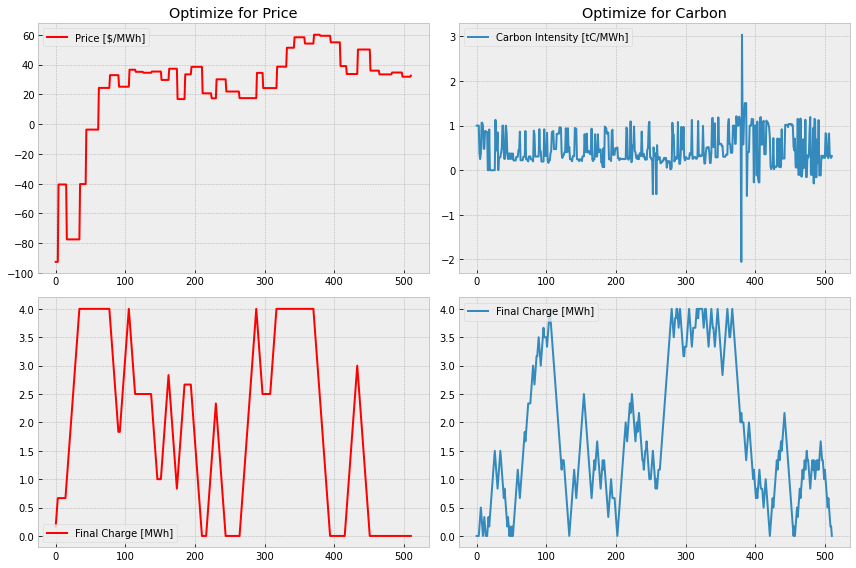

In [29]:
m = 24*12
n = 24*12*2

m = 0
n = -1

import matplotlib.pyplot as plt
plt.style.use('bmh')

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

pd.DataFrame(price).iloc[m:n, ].plot(y='Price [$/MWh]', ax=axes[0][0], color='red')
pd.DataFrame(price).iloc[m:n, ].plot(y='Final Charge [MWh]', ax=axes[1][0], color='red')
pd.DataFrame(carbon).iloc[m:n, ].plot(y='Final Charge [MWh]', ax=axes[1][1])
pd.DataFrame(carbon).iloc[m:n, ].plot(y='Carbon Intensity [tC/MWh]', ax=axes[0][1])

axes[0][0].set_title('Optimize for Price')
axes[0][1].set_title('Optimize for Carbon')

plt.tight_layout()
f.savefig('/Users/adam/adgefficiency.github.io/assets/space-between/panel.png')
#for ax in axes.flatten():
#    ax.get_legend().remove()

In [30]:
ds.columns

Index(['RRP', 'Increase'], dtype='object')

/Users/adam/.pyenv/versions/3.7.9/envs/epl/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/adam/.pyenv/versions/3.7.9/envs/epl/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log-price', ylabel='log-carbon'>

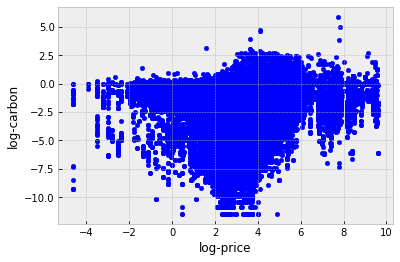

In [31]:
ds['log-price'] = np.log(ds['RRP'])
ds['log-carbon'] = np.log(ds['Increase'])
ds.plot(x='log-price', y='log-carbon', kind='scatter')